In [1]:
#import related packges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#define the function of read file
def loadfile(dir_path,filename):
	df=pd.read_csv(os.path.join(dir_path,filename),header=None)
	return df

In [3]:
#load files
dir_path='G:\py_lernen\motorTemperaturePrediction'

data=pd.read_csv('G:\py_lernen\motorTemperaturePrediction\measures_v2.csv')

In [4]:
#preprocessing of data

#split dataset into trainset and testset
testset=data[(data['profile_id']==72)]
trainset=data[(data['profile_id']!=65) & (data['profile_id']!=72)]
validatset=data[(data['profile_id']==65)]


In [5]:
#new feature i_s, v_s and apparent work
def norm(row,col1,col2):
	return np.linalg.norm([row[col1],row[col2]])



def find_new_feature(df):
	extra_df=df.copy()

	extra_df['voltage_s']=extra_df.apply(norm,args=('u_d','u_q'),axis=1)
	extra_df['current_s']=extra_df.apply(norm,args=('i_d','i_q'),axis=1)
	extra_df['apparent_power']=1.5*extra_df['voltage_s']*extra_df['current_s']

	return extra_df

In [6]:
train_df=find_new_feature(trainset)
test_df=find_new_feature(testset)
val_df=find_new_feature(validatset)

In [7]:
def plot_per_id(df,id):
    cols=df.columns
    profile_id=np.array(df['profile_id'])
    
    for col in cols:
        figure = plt.figure(figsize=(14,4))
        ax = plt.gca()
        ax.plot(df.index.values[profile_id==id], df[col][profile_id==id])
        ax.set_xlabel("time")
        ax.set_ylabel(col)
        ax.set_title("{} as a function of time".format(col))

        plt.show()
    

In [8]:
# plot_per_id(train_df,55)

In [9]:
list = train_df["profile_id"].unique()
list.sort()
print("Unique profiles: {}".format(list))

Unique profiles: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 26 27
 29 30 31 32 36 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 66 67 68 69 70 71 73 74 75 76 78 79 80 81]


In [10]:


# train_df_smooth=train_df[(train_df['profile_id']==20)]


# col_to_smooth='ambient'
# train_df_smooth_copy=train_df_smooth.copy()
# train_df_smooth_copy['ambient smooth']=savgol_filter(train_df_smooth_copy[col_to_smooth,101,1)

# # print(train_df_smooth_copy.head(3))


In [11]:
#smooth signal
from scipy.signal import savgol_filter

def smooth_func(df,col_to_smooth):
    df[col_to_smooth+'_smoothed']=savgol_filter(df[col_to_smooth],201,1)
    return df

In [12]:
train_df_copy=train_df.copy()
test_df_copy=test_df.copy()
val_df_copy=val_df.copy()

In [13]:
# train_df_copy
# train_df_copy=train_df_20.copy()

# train_df_copy['ambient_smooth']=savgol_filter(train_df_copy['ambient'],101,polyorder=1)

In [14]:

col='ambient'
train_df_copy=smooth_func(train_df_copy,col)
test_df_copy=smooth_func(test_df_copy,col)
val_df_copy=smooth_func(val_df_copy,col)
# print(train_df_copy.columns)

In [16]:
train_df_copy.drop(['ambient','stator_yoke','stator_winding','stator_tooth','torque'],axis=1)
test_df_copy.drop(['ambient','stator_yoke','stator_winding','stator_tooth','torque'],axis=1)
val_df_copy.drop(['ambient','stator_yoke','stator_winding','stator_tooth','torque'],axis=1)

,u_q,coolant,u_d,motor_speed,i_d,i_q,pm,profile_id,voltage_s,current_s,apparent_power,ambient_smoothed
1042494,-0.060301,24.572270,-0.044640,3028.577653,-16.682717,-22.554878,26.037928,65,0.075026,28.054154,3.157200,25.082247
1042495,-0.098472,24.549411,-0.087538,3277.195135,-32.674103,-36.837572,26.171841,65,0.131756,49.240265,9.731557,25.082156
1042496,-0.134579,24.529792,-0.137843,3526.252702,-51.436325,-50.341317,25.995341,65,0.192645,71.971826,20.797563,25.082065
1042497,-0.163837,24.506268,-0.188305,3775.622429,-70.247635,-61.302441,25.900132,65,0.249602,93.234755,34.907400,25.081974
1042498,-0.185884,24.494794,-0.235406,4025.182345,-87.820645,-69.577852,25.862153,65,0.299948,112.042596,50.410471,25.081884
...,...,...,...,...,...,...,...,...,...,...,...,...
1082583,58.732574,54.234283,113.107700,2475.614605,-106.013023,-155.533385,86.033969,65,127.447508,188.226977,35983.588670,27.873669
1082584,59.347737,54.234283,112.063716,2497.023037,-109.789794,-154.783568,86.033969,65,126.808636,189.767625,36096.260698,27.874340
1082585,56.137882,54.234283,108.349656,2515.413765,-124.216542,-152.945533,86.033969,65,122.029135,197.033208,36065.687934,27.875012
1082586,50.692137,54.234283,104.121110,2529.231155,-140.955000,-149.690989,86.033969,65,115.805433,205.610565,35716.230812,27.875683


In [17]:
Y_train=train_df_copy.pop('pm')
Y_val=val_df_copy.pop('pm')
Y_test=test_df_copy.pop('pm')


X_train=train_df_copy.drop('profile_id',axis=1)
X_val=val_df_copy.drop('profile_id',axis=1)
X_test=test_df_copy.drop('profile_id',axis=1)

In [19]:
model_linear=LinearRegression()

model_linear.fit(X_train,Y_train)

y_pred=model_linear.predict(X_val)

In [25]:
print(type(y_pred))

<class 'numpy.ndarray'>


In [26]:
a=savgol_filter(y_pred,101,1)

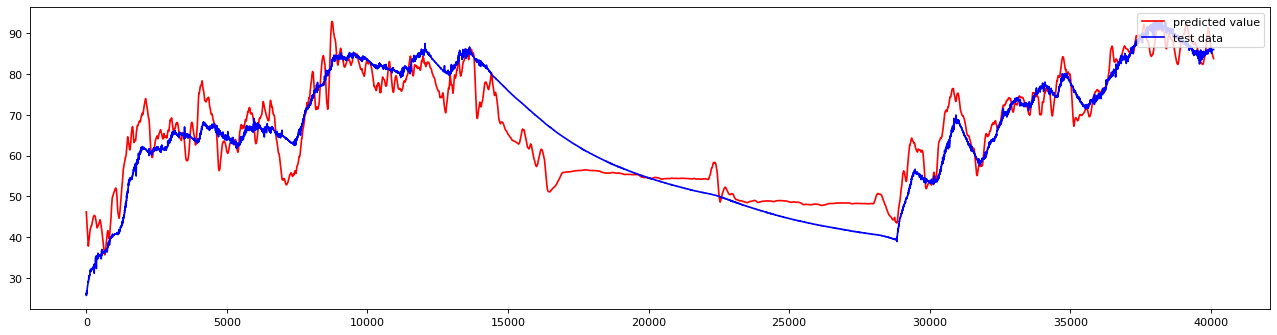

In [38]:
# plot
plt.figure(figsize=(20,5),dpi=80)
plt.plot(a,'r')
plt.plot(Y_val.values,'b')
plt.legend(('predicted value','test data'),loc='upper right')

In [43]:
print('MAE:', mean_absolute_error(Y_val, a))
print('MSE:',mean_squared_error(a, Y_val))
print("预测性能得分: %.2f" % model_linear.score(X_val, y_pred))

MAE: 4.201503257963121
MSE: 28.593971645762235
预测性能得分: 1.00


In [39]:
#RandomForesstRegressor
from sklearn.ensemble import RandomForestRegressor
model_RFR=RandomForestRegressor(n_estimators=10,random_state=1)
model_RFR.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

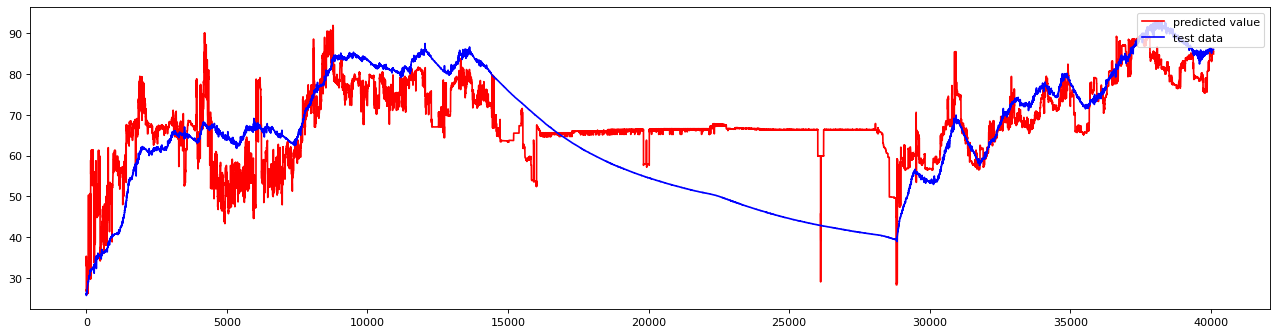

In [40]:
y_pred_rfr=model_RFR.predict(X_val)
# plot
plt.figure(figsize=(20,5),dpi=80)
plt.plot(y_pred_rfr,'r')
plt.plot(Y_val.values,'b')
plt.legend(('predicted value','test data'),loc='upper right')

In [42]:
print('MAE:', mean_absolute_error(Y_val, y_pred_rfr))
print('MSE:',mean_squared_error(y_pred_rfr, Y_val))
print("预测性能得分: %.2f" % model_linear.score(X_val, y_pred_rfr))

MAE: 9.33369392135503
MSE: 136.39578491032276
预测性能得分: -0.17


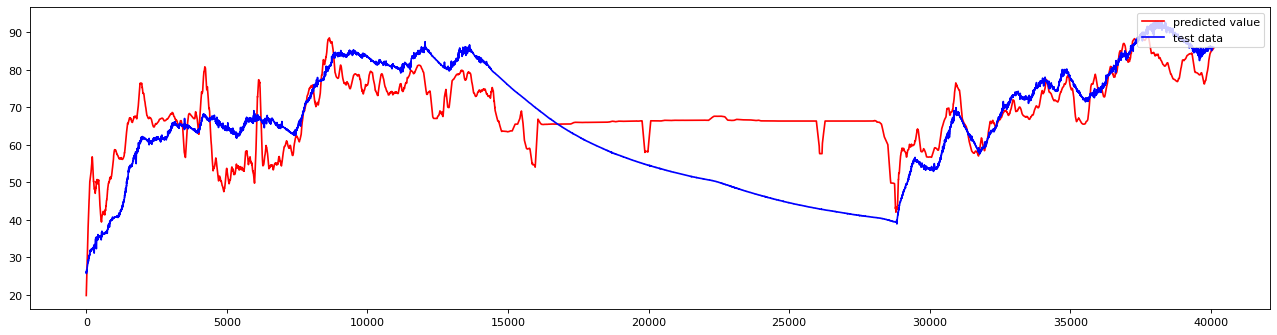

In [45]:
b=savgol_filter(y_pred_rfr,101,1)
# plot
plt.figure(figsize=(20,5),dpi=80)
plt.plot(b,'r')
plt.plot(Y_val.values,'b')
plt.legend(('predicted value','test data'),loc='upper right')